In [47]:
import pandas as pd
import numpy as np
import scipy.misc, scipy.signal, scipy.ndimage
from skimage.restoration import inpaint
from PIL import Image
from matplotlib.gridspec import GridSpec
import glob
from tqdm import tnrange, tqdm_notebook
from ipywidgets import interact, IntSlider

import sys
sys.path.append('../src')

from multithreading import *
from plot_utils import *

%load_ext autoreload
%aimport multithreading
%aimport plot_utils
%autoreload 1

DATA_PATH = '../data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Wafer preprocessing algorithm
1. Determine wafer shape mask
    1. Binarize - all values replace with 1, all *NaN* replace with 0
    2. Fill holes in using binary dilations
2. Median absolute deviation to detect outliers
3. Replace outliers with *NaN*s
4. Determine all missing regions in wafer using shape mask and fill them with biharmonic inpaint algorithm
5. (Optional) Apply median filter to smoothen wafer
6. (Optional) Normalize values

In [48]:
def mad_based_outlier(y, thresh=3.5, twoside=True):
    m = np.nanmedian(y)
    abs_dev = np.abs(y - m)
    if twoside:
        #print('twoside', twoside)
        left_mad = np.nanmedian(abs_dev[y <= m])
        right_mad = np.nanmedian(abs_dev[y >= m])
        y_mad = left_mad * np.ones(len(y))
        y_mad[y > m] = right_mad
    else:
        #print('twoside', twoside)
        y_mad = np.nanmedian(abs_dev)
    modified_z_score = 0.6745 * abs_dev / y_mad
    modified_z_score[y == m] = 0
    return modified_z_score > thresh

def mad_based_outlier2(y, thresh=3.5):
    m = np.nanmedian(y)
    abs_dev = np.abs(y - m)
    left_mad = np.nanmedian(abs_dev[y <= m])
    right_mad = np.nanmedian(abs_dev[y >= m])
    left_sigma = 1.4826 * left_mad
    right_sigma = 1.4826 * right_mad
    outliers = []
    for x in y:
        if abs(x - m)/left_sigma > 3.5 or abs(x - m)/right_sigma > 3.5:
           print('outlier: %d' % x) 

def mdm_based_outlier(y, thresh=3.5):
    m = np.nanmedian(y)
    abs_dev = np.abs(y - m)
    left_mad = np.nanmedian(np.nanmedian(abs_dev[y <= m]))
    right_mad = np.nanmedian(np.nanmedian(abs_dev[y >= m]))
    y_mad = left_mad * np.ones(len(y))
    y_mad[y > m] = right_mad
    modified_z_score = abs_dev / (1.1926 * y_mad)
    modified_z_score[y == m] = 0
    return modified_z_score > thresh

def iqr_based_outlier(y, k=1.5):
    q1, q3 = np.nanpercentile(y, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * k)
    upper_bound = q3 + (iqr * k)
    print(y, q1, q3, lower_bound, upper_bound)
    return (y > upper_bound) | (y < lower_bound)

def clean_wafer(arr, outlier_method='mad', median_filter=False, normalize=True):    
    mask = np.copy(arr)
    mask[~np.isnan(mask)] = 1
    mask[np.isnan(mask)] = 0
    mask = scipy.ndimage.morphology.binary_fill_holes(mask)
    if outlier_method =="mad":
        print("mad")
    
    # default outlier detection
    outliers = mad_based_outlier(arr.flatten()).reshape(arr.shape)
    if outlier_method == 'mad':
        print('mad')
        outliers = mad_based_outlier(arr.flatten()).reshape(arr.shape)
    elif outlier_method == 'mdm':
        print('mdm')
        outliers = mdm_based_outlier(arr.flatten()).reshape(arr.shape)
    elif outlier_method == 'iqr':
        print('iqr')
        outliers = iqr_based_outlier(arr.flatten()).reshape(arr.shape)
        print(outliers)
    arr[outliers] = np.nan
    mask[~np.isnan(arr)] = 0

    arr = inpaint.inpaint_biharmonic(arr, mask)

    if median_filter:
        arr = scipy.signal.medfilt2d(arr)

    if normalize:
        min, max = np.nanmin(arr), np.nanmax(arr)
        arr = (0.95 * (arr - min)) / (max - min) + 0.05
        arr = np.nan_to_num(arr)

        # Resize to 128x128px + 5px border
        '''
        img = Image.fromarray(np.uint8((arr + 1) * 127))
        img = img.resize((128, 128), Image.ANTIALIAS)
        arr = np.array(img)
        arr = arr / 128 - 1
        '''

    return arr

In [49]:
mad_based_outlier2([5,3,4,4.5,5.5,19,-82,5.3,5.1,120])
print(mad_based_outlier([5,3,4,4.5,5.5,19,-82,5.3,5.1,120]))

outlier: 19
outlier: -82
outlier: 120
[False False False False False  True  True False False  True]


# Generate clean version of data

In [50]:
files = glob.glob(DATA_PATH + '/*.eff')
out = []

for file in files:
    print('Reading lot: ' + file)
    data = pd.read_csv(file, index_col=False, sep=';', skiprows=[2,3], header=1)

    tests = []
    for wafer_id in np.unique(data['Wafer']):
        wafer = data.loc[data['Wafer'] == wafer_id]
        for test_name in [x for x in list(wafer) if 'Test_' in x]:
            test = wafer.pivot('Y', 'X', test_name).values
            tests.append(test)

    def process_test(test_data):
        clean = clean_wafer(test_data, True)
        return clean

    out.extend(parallel_process(tests, process_test))

out = np.array(out)
print(out.shape)

np.save(DATA_PATH + '/clean.npy', out)

Reading lot: ../data/Product1_Lot1_S1.eff


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(63, 193, 115)


# Visualize some cleaned wafers

In [14]:
file = glob.glob(DATA_PATH + '/*.eff')[0]
out = []

print('Reading lot: ' + file)
data = pd.read_csv(file, index_col=False, sep=';', skiprows=[2,3], header=1)

Reading lot: ../data2/Product1_Lot2_S1.eff


(193, 115)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


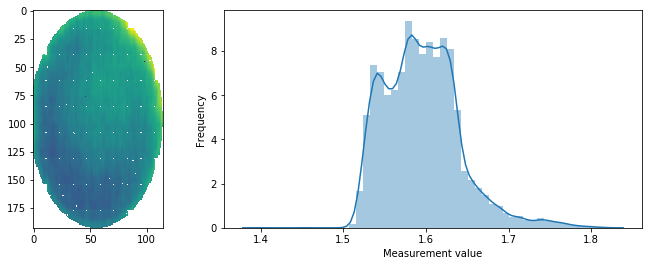

mad
mdm


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


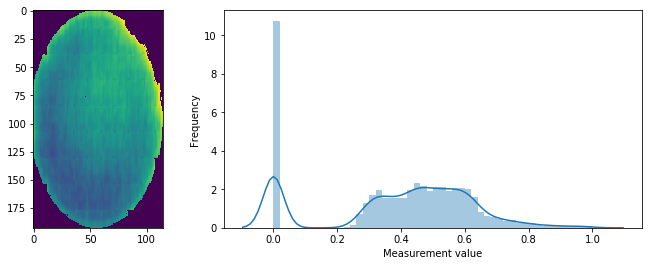

mdm


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less_equal
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


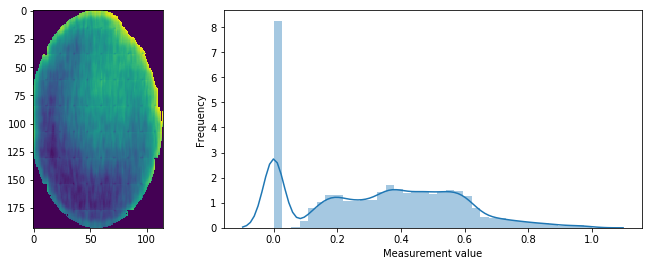

iqr
[nan nan nan ... nan nan nan] 1.5602610000000001 1.621637 1.4681970000000004 1.713701
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less


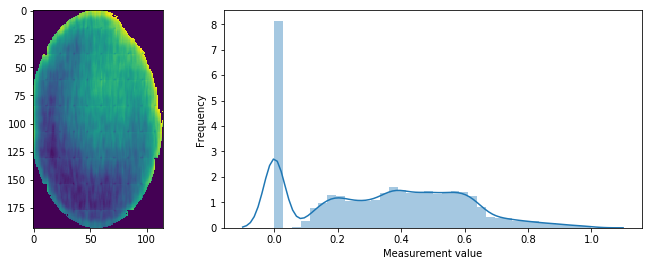

In [51]:
wafer = data.loc[data['Wafer'] == 2]
test = wafer.pivot('Y', 'X', 'Test_13').values
plt.rcParams['image.cmap'] = 'viridis'
print(test.shape)
plot_wafer(test)
clean = clean_wafer(np.copy(test))
plot_wafer(clean)
clean = clean_wafer(test, outlier_method='mdm')
plot_wafer(clean)
clean = clean_wafer(test, outlier_method='iqr')
plot_wafer(clean)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


mad
mdm


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


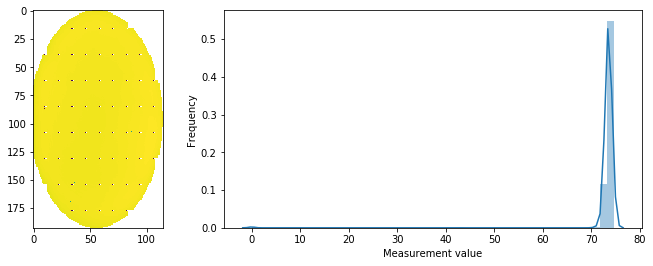

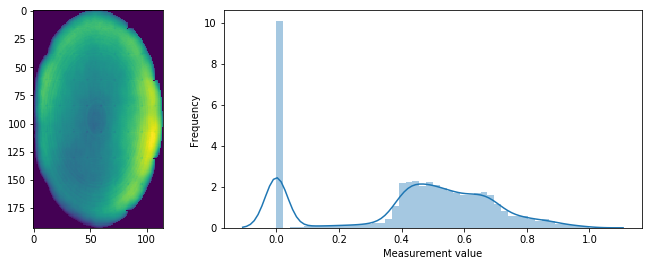

In [52]:
wafer = data.loc[data['Wafer'] == 1]
test = wafer.pivot('Y', 'X', 'Test_7').values
plot_wafer(test, 'r1.pdf')

clean = clean_wafer(test)
plot_wafer(clean, 'r2.pdf')

#plot_wafer(test, 'r2-raw.pdf')
#plot_wafer(clean, 'r2-clean.pdf')

In [17]:
clean = np.load(DATA_PATH + '/clean.npy')

def wafer_slider(wafer):
    plot_wafer(clean[wafer])

interact(wafer_slider, wafer=IntSlider(min=0, max=clean.shape[0]-1, step=1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='wafer', max=2057), Output()), _…

<function __main__.wafer_slider>